In [2]:
import io
import os
import pathlib
import requests
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import dummy, ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick


In [3]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [4]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [6]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

features_preprocessing = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
        **vectorizer_hyperparams,
    ),
    preprocessing.FunctionTransformer(lambda csr: csr.toarray(), lambda arr: sparse.csr_matrix(arr))
)

label_encoder = preprocessing.LabelEncoder()

In [7]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = label_encoder.fit_transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = label_encoder.fit_transform(test_df.loc[:, "sentiment"])


In [ ]:
xgb.XGBClassifier?

In [8]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [9]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.910925
Validation accuracy: 0.7668


In [15]:
xgb_classifier = xgb.XGBClassifier(
    early_stopping_rounds=10,
    random_state=42
)
xgb_classifier.fit(
    X_train,
    y_train,
    eval_set=[
        (X_train, y_train),
        (X_val, y_val)
    ]
)

[0]	validation_0-logloss:0.64352	validation_1-logloss:0.64786
[1]	validation_0-logloss:0.61243	validation_1-logloss:0.62099
[2]	validation_0-logloss:0.59122	validation_1-logloss:0.60340
[3]	validation_0-logloss:0.57483	validation_1-logloss:0.59166
[4]	validation_0-logloss:0.56156	validation_1-logloss:0.58068
[5]	validation_0-logloss:0.54888	validation_1-logloss:0.57344
[6]	validation_0-logloss:0.53739	validation_1-logloss:0.56596
[7]	validation_0-logloss:0.52747	validation_1-logloss:0.56024
[8]	validation_0-logloss:0.51829	validation_1-logloss:0.55396
[9]	validation_0-logloss:0.51058	validation_1-logloss:0.54899
[10]	validation_0-logloss:0.50264	validation_1-logloss:0.54484
[11]	validation_0-logloss:0.49486	validation_1-logloss:0.54002
[12]	validation_0-logloss:0.48803	validation_1-logloss:0.53513
[13]	validation_0-logloss:0.48197	validation_1-logloss:0.53195
[14]	validation_0-logloss:0.47651	validation_1-logloss:0.52990
[15]	validation_0-logloss:0.47089	validation_1-logloss:0.52755
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [16]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.877225
Validation accuracy: 0.7664


In [17]:
xgb_classifier.best_ntree_limit

61

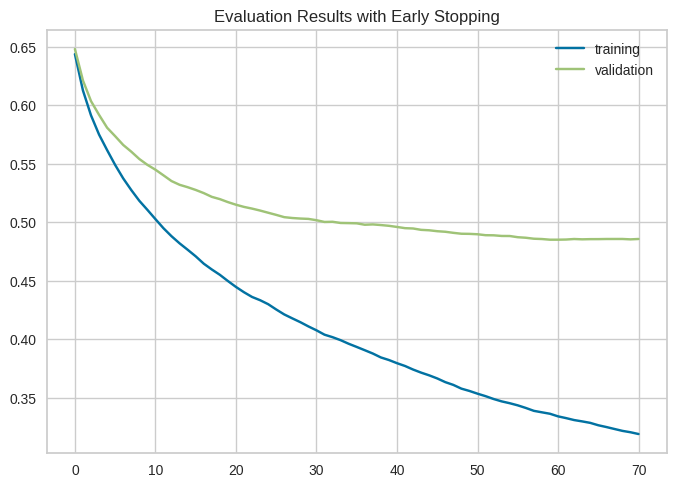

In [18]:
eval_result = xgb_classifier.evals_result()
_ = (pd.DataFrame
   .from_dict(
      {
          "training": eval_result["validation_0"]["logloss"],
          "validation": eval_result["validation_1"]["logloss"]
      }
   ).plot(title="Evaluation Results with Early Stopping")
)

In [19]:
xgb_classifier = xgb.XGBClassifier(
    n_estimators=61,
    random_state=42
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=61, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [20]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.877225
Validation accuracy: 0.7664


In [21]:
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [22]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.910925
Validation accuracy: 0.7668


In [24]:
xgb_classifier = xgb.XGBClassifier(
    early_stopping_rounds=10,
    eval_metric="error",
    random_state=42
)
xgb_classifier.fit(
    X_train,
    y_train,
    eval_set=[
        (X_train, y_train),
        (X_val, y_val)
    ]
)

[0]	validation_0-error:0.32630	validation_1-error:0.33520
[1]	validation_0-error:0.29985	validation_1-error:0.31220
[2]	validation_0-error:0.28728	validation_1-error:0.30100
[3]	validation_0-error:0.28058	validation_1-error:0.29880
[4]	validation_0-error:0.27182	validation_1-error:0.28800
[5]	validation_0-error:0.26070	validation_1-error:0.28660
[6]	validation_0-error:0.25355	validation_1-error:0.28100
[7]	validation_0-error:0.24582	validation_1-error:0.28180
[8]	validation_0-error:0.24045	validation_1-error:0.27920
[9]	validation_0-error:0.23395	validation_1-error:0.27280
[10]	validation_0-error:0.22730	validation_1-error:0.27100
[11]	validation_0-error:0.22270	validation_1-error:0.26860
[12]	validation_0-error:0.21850	validation_1-error:0.26360
[13]	validation_0-error:0.21638	validation_1-error:0.26020
[14]	validation_0-error:0.21233	validation_1-error:0.25920
[15]	validation_0-error:0.20855	validation_1-error:0.25680
[16]	validation_0-error:0.20475	validation_1-error:0.25400
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [25]:
xgb_classifier.best_ntree_limit

67

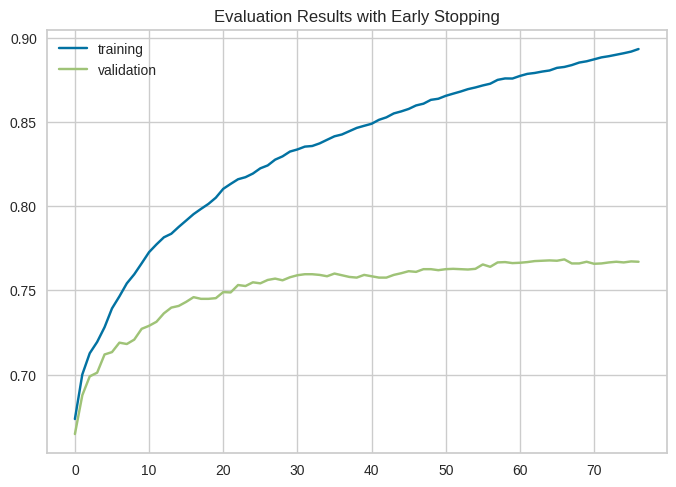

In [27]:
eval_result = xgb_classifier.evals_result()
_ = (pd.DataFrame
   .from_dict(
      {
          "training": 1 - np.array(eval_result["validation_0"]["error"]),
          "validation": 1 - np.array(eval_result["validation_1"]["error"])
      }
   ).plot(title="Evaluation Results with Early Stopping")
)